# Inspect and Verify that the Forced Source Table is reasonable
Michael Wood-Vasey

To test the Source Table before it's in production we use a copy of our local branch of `gcr-catalogs`, `issues/279`.
Replace the path below in the `sys.path.insert` with the location of your own local checkout.

In [2]:
import sys
sys.path.insert(0, '/global/homes/w/wmwv/local/lsst/gcr-catalogs')

In [3]:
import os

import numpy as np
import pandas as pd

import GCRCatalogs

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
object_reader = 'dc2_object_run1.2p'
source_reader = 'dc2_source_run1.2p'
forced_source_reader = 'dc2_forced_source_run1.2p'

In [6]:
dpdd_parquet_file = 'dpdd_dc2_object_run1.2p.parquet'
dpdd_parquet_dir = '/global/projecta/projectdirs/lsst/global/in2p3/Run1.2p/object_catalog'
object_table_parquet_file = os.path.join(dpdd_parquet_dir, dpdd_parquet_file)

In [7]:
forced_src_config = {'base_dir': '/global/cscratch1/sd/wmwv/DC2/Run1.2p/forced_src_visit',
                     'filename_pattern': 'forced_src_visit_988529.parquet'}

In [8]:
# object_table = GCRCatalogs.load_catalog(object_reader)
object_table = pd.read_parquet(object_table_parquet_file)

In [9]:
source_table = GCRCatalogs.load_catalog(source_reader, config_overwrite={'filename_pattern': 'src_visit_988529.parquet'})

In [10]:
forced_source_table = GCRCatalogs.load_catalog(forced_source_reader, config_overwrite=forced_src_config)

In [11]:
len(forced_source_table)

480433

The Run 1.2p Forced Source table has 324 million measurements across 6 filters and 1991 visits.  There were 1991 visits that generated source catalogs for Run 1.2p, so it's good to see that all of those produced forced-source catalogs.

Text(0.5,0,'base_PsfFlux_instFluxErr')

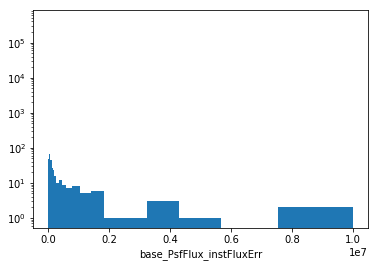

In [12]:
w = np.isfinite(forced_source_table['base_PsfFlux_instFluxErr'])
plt.hist(forced_source_table['base_PsfFlux_instFluxErr'][w], log=True, bins=np.logspace(1,7));
plt.xlabel('base_PsfFlux_instFluxErr')

In [13]:
forced_source_table['base_PsfFlux_instFluxErr']

array([5857.46011563,  577.09599572,  556.9233528 , ...,  127.33502805,
        128.08698456,  126.85036855])

In [14]:
import seaborn as sns
def plot_mag_magerr(cat, mag_err_lim=0.5):
    good = cat[cat['magerr'] < mag_err_lim]
    with sns.axes_style("white"):
        sns.jointplot(x=good['mag'], y=good['magerr'], kind='kde',
                      xlim=(15, 26), ylim=(0, mag_err_lim))

In [15]:
src = pd.DataFrame(source_table.get_quantities(['mag', 'magerr']))

In [16]:
forced_src = pd.DataFrame(forced_source_table.get_quantities(['mag', 'magerr']))

In [17]:
len(src), len(forced_src)

(207707, 480433)

In [18]:
forced_source_table.list_all_quantities()

['visit',
 'psFlux',
 'clean',
 'detector',
 'objectId',
 'fluxmag0',
 'good',
 'psFluxErr',
 'filter',
 'mag',
 'id',
 'psFlux_flag',
 'magerr']

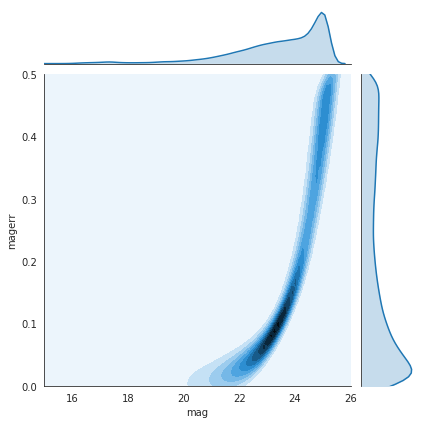

In [19]:
plot_mag_magerr(forced_src)

In [20]:
visits = set(forced_source_table['visit'])
print(len(visits))

1


------

In [21]:
def plot_mag_magerr_2dhist(cat):
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))

    axes[0, 0].hist(cat['mag'], range=(15, 26), bins=111)
    im = axes[1, 0].hexbin(cat['mag'], cat['magerr'], extent=(15, 26, 0, 0.5), cmap='CMRmap_r')
    axes[1, 0].set_xlabel('mag')
    axes[1, 0].set_ylabel('magerr')
    plt.colorbar(im, label='counts/bin', ax=axes[0, 1], orientation='horizontal')
    
    axes[1, 1].hist(cat['magerr'], range=(0, 0.5), bins=21, orientation='horizontal')

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


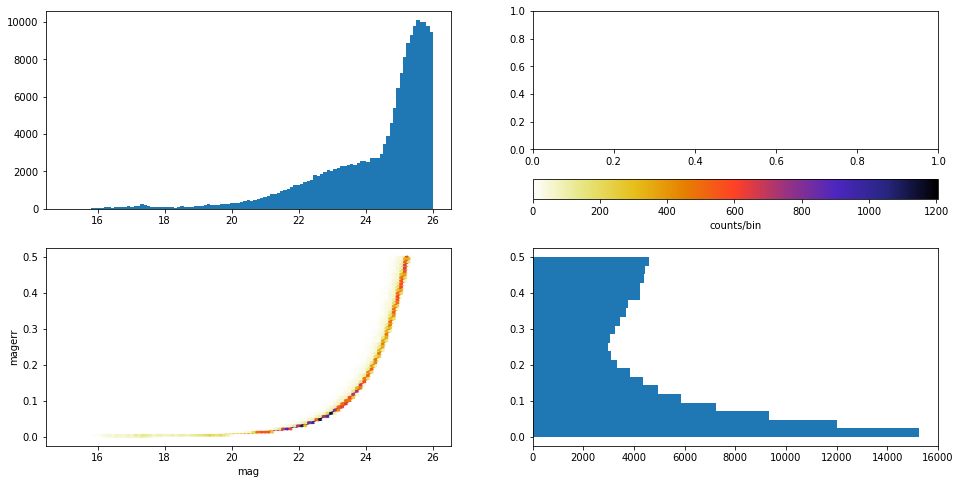

In [22]:
plot_mag_magerr_2dhist(forced_src)

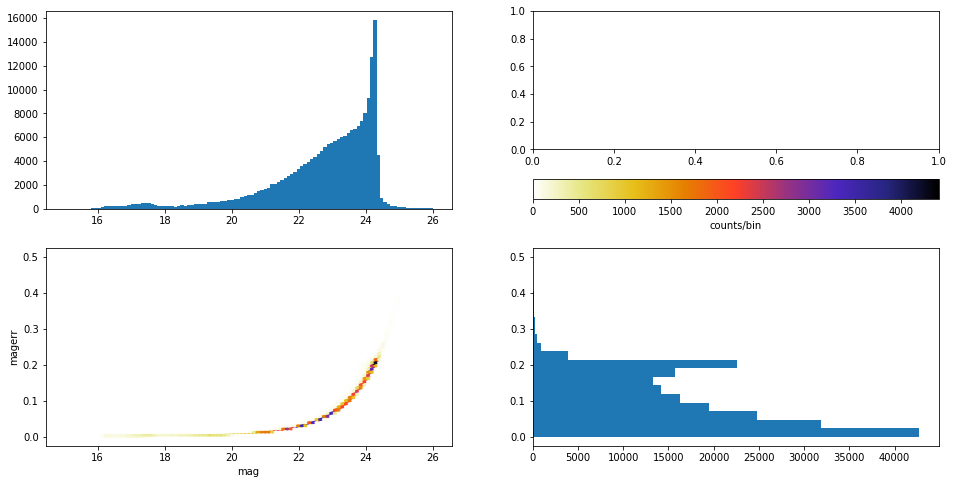

In [23]:
plot_mag_magerr_2dhist(src)

------

How do the source catalog and forced-source catalog measurement scompare for the same ObjectID?

In [24]:
src_cat = pd.DataFrame(source_table.get_quantities(['objectId', 'ra', 'dec', 'id', 'psFlux', 'psFluxErr', 'mag', 'magerr']))

In [25]:
forced_src_cat = pd.DataFrame(forced_source_table.get_quantities(['objectId', 'psFlux', 'psFluxErr', 'mag', 'magerr']))

In [26]:
joined_src_cat = pd.merge(src_cat, forced_src_cat, left_on='objectId', right_on='objectId', how='inner', suffixes=('', '_forced'))

In [27]:
len(joined_src_cat)

45214

In [28]:
for suffix in '', '_forced':
    joined_src_cat['snr'+suffix] = joined_src_cat['psFlux'+suffix]/joined_src_cat['psFluxErr'+suffix]

In [29]:
joined_src_cat.dtypes

dec                 float64
psFlux              float64
objectId              int64
psFluxErr           float64
mag                 float64
ra                  float64
id                    int64
magerr              float64
psFlux_forced       float64
psFluxErr_forced    float64
mag_forced          float64
magerr_forced       float64
snr                 float64
snr_forced          float64
dtype: object

In [30]:
joined_src_cat[['mag', 'mag_forced']]

,mag,mag_forced
0,18.183786,17.850137
1,21.825448,21.819424
2,20.651000,20.635060
3,22.823456,22.829884
4,20.745815,20.745863
5,23.641117,23.676016
6,23.400581,23.541113
7,20.136600,20.136779
8,21.984206,21.984485
9,22.702436,22.704915


/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


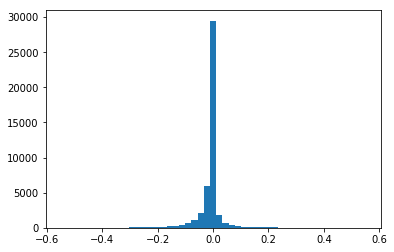

In [31]:
w = np.isfinite(joined_src_cat['mag']) * np.isfinite(joined_src_cat['mag_forced'])
plt.hist(joined_src_cat['mag'][w]-joined_src_cat['mag_forced'][w], bins=np.linspace(-0.55, +0.55));

There's a bias such that the source measurements are slightly brighter than the forced-source measurements because the source measurements are the result of detection+measurement on that image, while the forced-source measurements are the result of detection on a substantially deeper image and just measurement on the image in question.  Thus at the faint end, the source measurements that exist are for the objects that fluctuated brighter in that particular image.

More details on the agreement as function of magnitude next:

(0, 0.3)

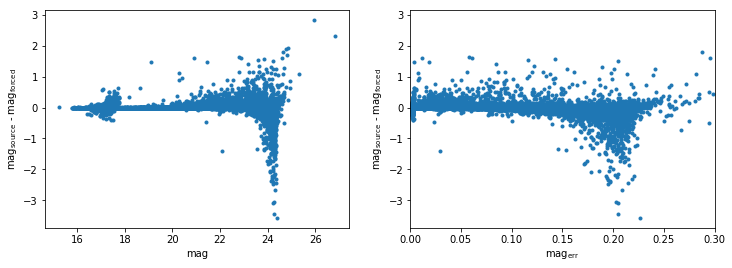

In [32]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
ax0.scatter(joined_src_cat['mag'], joined_src_cat['mag']-joined_src_cat['mag_forced'], marker='.')
ax0.set_xlabel('mag')
ax0.set_ylabel(r'mag$_{\rm source}$ - mag$_{\rm forced}$')

ax1.scatter(joined_src_cat['magerr'], joined_src_cat['mag']-joined_src_cat['mag_forced'], marker='.')
ax1.set_xlabel(r'mag$_{\rm err}$')
ax1.set_ylabel(r'mag$_{\rm source}$ - mag$_{\rm forced}$')
ax1.set_xlim(0, 0.3)

Magnitude error scales monotonically (and exponentially) with magnitude (as $\sigma_m \propto 10^{m/5}$), so the abscissa of the right plot is a non-uniformly scaled version of the plot on the left.

So the feature of the blog around 17 mag on the left plot gets squeezed up against mag_err~0 on the right plot.  And the faint end gets stretched out around mag_err~0.20.

The next plot of mag_err vs. mag shows the relationship.

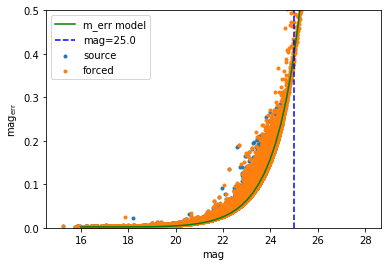

In [129]:
plt.scatter(joined_src_cat['mag'], joined_src_cat['magerr'], marker='.', label='source')
plt.xlabel('mag')
plt.ylabel(r'mag$_{\rm err}$')

plt.scatter(joined_src_cat['mag_forced'], joined_src_cat['magerr_forced'], marker='.', label='forced')

zp_one_electron = 26

m = np.linspace(16, 27.5)
m_err_floor = 0.002
m_err = np.sqrt(m_err_floor**2 + (10**((m-zp_one_electron)/2.5))**2)

plt.plot(m, m_err, color='green', label='m_err model')
plt.ylim(0, 0.5);

mag_faint_reference = 25
plt.axvline(mag_faint_reference, ls='--', color='blue', label='mag=%.1f' % mag_faint_reference);

plt.legend();

We can look at this in a slightly different way by looking at SNR vs. mag.  Because $\sigma_m \propto 1/{\rm SNR}$, looking at SNR will instead focus on structure at the bright end.

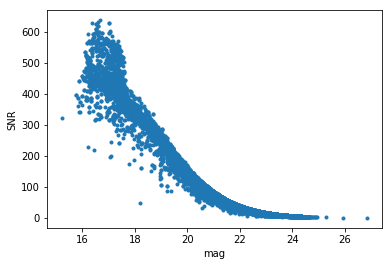

In [133]:
plt.scatter(joined_src_cat['mag'], joined_src_cat['snr'], label='source', marker='.')
plt.xlabel('mag')
plt.ylabel('SNR');

The Source and Forced Source agree in the mag vs. mag_err, which is reassuring.  This is essentially saying that the DM Science Pipeline is consistent in estimating photometric uncertainties between the source measurements and the forced-source measurements.

### Do we get the right $\sigma_f$ and $\sigma_m$ relationship?

1. The relationship between magnitude and flux 

$m = -2.5\log_{10}{f} + zp \approx -\frac{2.5}{2.3025851} \ln{f} \approx 1.086 \ln{f}$

(recalling that $\log_{10} f = \frac{1}{\ln{10}} \ln{f}$)

means

$\sigma_m = 1.086 \frac{\sigma_f}{f}$  
$\sigma_f = \frac{1}{1.086} f \sigma_m$.

A systematic floor that doesn't change the fundamental relationship between $m$ and $f$.  It just adds to the Poisson noise.

2. Poisson shot noise means that $\sigma_{f {\rm poisson}} = A \sqrt{f}$.  In addition there are limits at the faint and bright ends.  At the faint end, the sky background noise dominates and sets a constant flux uncertainty floor.  At the bright end, there's a systematic uncertainty from modeling of the PSF, aperture correction that sets a floor.

$\sigma_f^2 = \sigma_{f {\rm poisson}}^2 + \sigma_{f {\rm sky}}^2 + \sigma_{f {\rm sys}}^2$

The above fit implies a systematic floor of $\sigma_{m {\rm sys}}=0.002$ mag.  That corresponds to a $\sigma_{f {\rm sys}} = 1.086 f \sigma_{m {\rm sys}}$.

$\sigma_f^2 = \sigma_{f {\rm poisson}}^2 + \sigma_{f {\rm sky}}^2 + (0.4 f \sigma_{m {\rm sys}})^2$  
$\sigma_f^2 = A^2 f + \sigma_{f {\rm sky}}^2 + (1.086 \sigma_{m {\rm sys}})^2 f^2$


In [130]:
def plot_flux_flux_err(ax):
    ax.scatter(joined_src_cat['psFlux'], joined_src_cat['psFluxErr'], marker='.', label='source')
    ax.set_xlabel('flux')
    ax.set_ylabel(r'$\sigma_{\rm flux}$');

    ax.scatter(joined_src_cat['psFlux_forced'], joined_src_cat['psFluxErr_forced'], marker='.', label='forced')

    zp = np.nanmedian(joined_src_cat['mag'] + 2.5*np.log10(joined_src_cat['psFlux']))
    print("Zeropoint: ", zp)

    prefactor = 2.5 / np.log(10)
    f = 10**(-(m-zp)/2.5)
    f_err = prefactor * m_err * f

    # Conversion from flux in counts to flux in electrons.  Known from simulations.
    # Remember, we are looking at the forced photometry from the individual images.
    gain = 1.7
    sigma_sky = 133
    f_err_model = np.sqrt((gain * f)/gain**2 + sigma_sky**2 + (prefactor * m_err_floor)**2 * f**2)

    ax.plot(f, f_err, color='purple', label='flux_err from m_err')
    ax.plot(f, f_err_model, color='green', label='flux_err model')

    flux_faint_reference = 10**(-(mag_faint_reference - zp)/2.5)
    ax.axvline(flux_faint_reference, ls='--', color='blue', label='mag=%.1f' % mag_faint_reference)

    ax.legend();

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log10


Zeropoint:  31.4
Zeropoint:  31.4


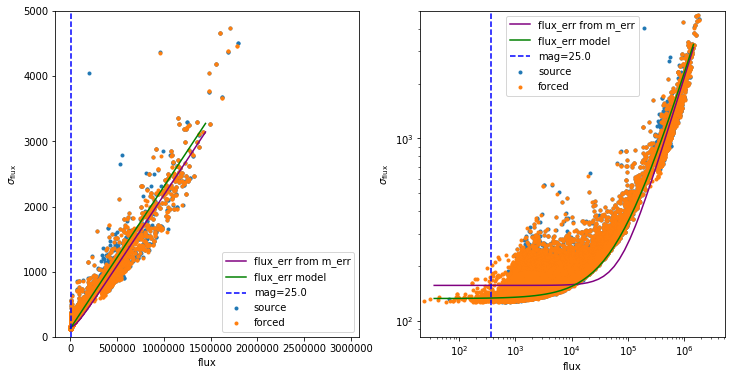

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plot_flux_flux_err(axes[0])
axes[0].set_ylim(0, 5e3)

plot_flux_flux_err(axes[1])
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_ylim(0, 5e3);

The flux err model looks reasonable.  It's a little easier to think through the contributions in flux space.  A model with the known gain, a reasonable sky estimate, and a ~0.2% photometric uncertainty floor explain the reported uncertainties well.  This model likely matches the internal Science Pipelines calculation approach.